In [1]:
from os.path import basename, exists

import warnings
warnings.filterwarnings('ignore')
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [3]:
import numpy as np

import random

import thinkstats2
import thinkplot

In [4]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [5]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [6]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [8]:
def checkPermPower(data):
        firsts = data[data.birthord == 1]
        others = data[data.birthord != 1]
    
        # Diff of means
        infile = firsts.prglngth.values, others.prglngth.values
        ht = DiffMeansPermute(infile)
        p_value1 = ht.PValue(iters=1000)
    
        # Chi Squared
        ht = PregLengthTest(infile)
        p_value2 = ht.PValue(iters=1000)
    
        # Correlation
        infile = data.dropna(subset=['agepreg', 'totalwgt_lb'])
        infile2 = infile.agepreg.values, infile.totalwgt_lb.values
        ht = CorrelationPermute(infile2)
        p_value3 = ht.PValue(iters=1000)
    
        print('%d\t%0.2f\t%0.2f\t%0.2f' % (n, p_value1, p_value2, p_value3))

In [9]:
import first
live, firsts, others = first.MakeFrames()

In [10]:
n=1000
for _ in range(7):
    sample = thinkstats2.SampleRows(live,900)
    checkPermPower(sample)
    n //= 2
 

1000	0.57	0.00	0.03
500	0.45	0.07	0.01
250	0.91	0.01	0.07
125	0.09	0.01	0.19
62	0.90	0.10	0.52
31	0.59	0.21	0.00
15	0.20	0.20	0.01


In [11]:
#Above tests shows that difference in means for pragnency lengths, chi-square test and correlation between age and weight of newborn, 
#the test is positive for for higher sample size but lower values shows positive outputs as well making it inconclusive.

Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. 
How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? 
If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. 
In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, 
to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. 
How much does correct weighting affect the estimates?

In [13]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [14]:
import brfss
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [15]:
#linear least squares fit
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope 

(0.9930804163932894, 0.005281454169417767)

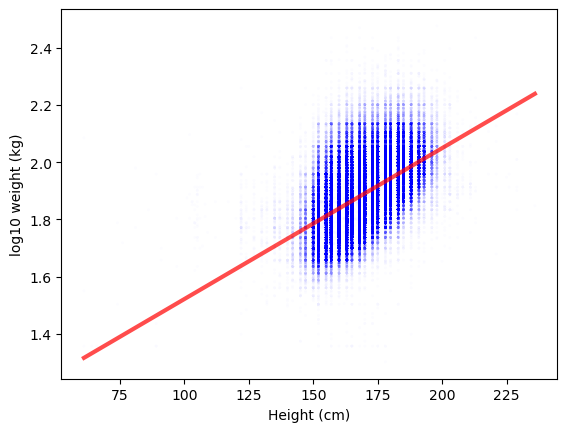

In [16]:
#Plot height vs weight

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

the best way to represent the output in this situation when one variable is log trasformed vs other is by exponentiating the variable to normal scale as shown below


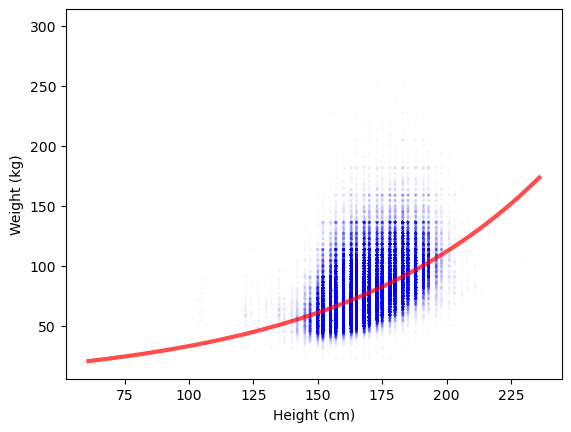

In [18]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

In [19]:
#standard deviation of the residuals from linear regresson model
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
std_res = thinkstats2.Std(res)
std_res

0.08740777080416452

In [20]:
#standard deviation of the log weights
stddev = thinkstats2.Std(log_weights)
stddev

0.10320725030003608

In [21]:
# Coeff of dtermination 
1 - std_res / stddev

0.1530849765877934

If you were trying to guess someone’s weight, 0.15 would be the RMSE for their height.

In [23]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

Resampling without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval

In [25]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.9591543382041 0.01836566993705874 (168.92297742476606, 168.98764374785262)


Resampling with weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval

In [27]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [49]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.4980025364296 0.016622647253780286 (170.46684199357304, 170.5258670344995)


Correct weighting affects the height by 1.5cm.